# Generative Gaussian Models

We'll use again the *iris* dataset, and solve the iris classification prolem using Gaussian classifiers.

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from load_dataset import loadDataSet                                #for loading the dataset
from train_validation_split import splitTrainingValidation          #for splitting the dataset into training and validation sets
from mean_covariance import vcol, vrow, compute_mu_C                #for computing the empirical mean and the empirical covariance of the dataset 
from logpdf_loglikelihood_GAU import logpdf_GAU_ND                  #for computing the log-likelihood of the Gaussian distribution
from sklearn.metrics import classification_report                   #for generating the classification report of the models
from scipy.special import logsumexp                                 #for scipy.special.logsumexp

In [140]:
numFeatures = 4

#load the iris dataset
D, L = loadDataSet('iris.csv', numFeatures)
print("Data shape: ", D.shape)
print("Labels shape: ", L.shape)

Data shape:  (4, 150)
Labels shape:  (150,)


In [141]:
#split the dataset into training and validation sets
#DTR and LTR are training data and labels, DTE and LTE are evaluation (or more precisely validation) data and labels
(DTR, LTR), (DVAL, LVAL) = splitTrainingValidation(2/3, D, L)
print("Training data shape: ", DTR.shape)
print("Training labels shape: ", LTR.shape)
print("Evaluation data shape: ", DVAL.shape)
print("Evaluation labels shape: ", LVAL.shape)

Training data shape:  (4, 100)
Training labels shape:  (100,)
Evaluation data shape:  (4, 50)
Evaluation labels shape:  (50,)


We use 100 samples for training and 50 samples for evaluation.

## Multivariate Gaussian Classifier
The optimal Bayes decision is to select for each test point the class with highest **posterior probability**: having class $c$ and $x_{t}$ as test point, we can thus write:
$$
c_{t}^{*} = argmax_{c} P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t) \rightarrow We \space assign \space x_{t} \space to \space the \space class \space having \space the \space highest \space Posterior \space probability
$$ 
We will assume that the samples are independent and identically distributed (*i.i.d.*) according to $(\mathbf{X}_t, C_{t}) ∼ (\mathbf{X}, C)$. <br>
Let $f_{X,C}$ be the joint density of $X, C$: we can
compute the joint likelihood for the hypothesized class $c$ for the observed test
sample $x_{t}$ as $f_{X,C}(x_{t}, c)$ and then use **Bayes rule** to compute the class posterior
probability:
$$
P(C_t = c \mid \mathbf{X}_t = \mathbf{x}_t) = \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{\sum_{c' \in C} f_{\mathbf{X},C}(\mathbf{x}_t, c')}
$$
We can factorize the joint density as:
$$
f_{\mathbf{X}_t, C_t}(\mathbf{x}_t, c) = f_{\mathbf{X} \mid C}(\mathbf{x}_t \mid c) P(c)
$$
Where:
- $f_{\mathbf{X} \mid C}(\mathbf{x}_t \mid c)$ is the class conditional distribution 
- $P(c)$ is called *Prior probabilty*: it's application-dependent and describes the probability of the class being $c$ **before** we observe $x_{t}$ 

In this specific case, we assume that our data, given the class, can be described by a **Gaussian distribution**:
$$
(\mathbf{X}_t \mid C_{t} = c) ∼ (\mathbf{X} \mid C = c) ∼ \mathcal{N}(\mathbf{µ_{c}}, \mathbf{Σ_{c}})
$$
If we knew $\mathbf{µ_{c}}$, $\mathbf{Σ_{c}}$ then we could compute the conditional this way;
$$
f_{\mathbf{X} \mid C}(\mathbf{x}_t \mid c) = \mathcal{N}(\mathbf{µ_{c}}, \mathbf{Σ_{c}})
$$
The problem is that we don't have **these parameters** $\theta = [(\mathbf{µ_{1}}, \mathbf{Σ_{1}}), . . . ,(\mathbf{µ_{k}}, \mathbf{Σ_{k}})] $, where $k$ is the number of different classes. <br>
However, since we have at our disposal a *labeled Dataset*, we can assume:
- Gaussian distribution for $\mathbf{X} \mid C$
- That, given the model parameters $\theta$, all the samples observations are *i.i.d* 

After (and only after) making these assumptions, we can plug in the **Maximum Likelihood Estimators** (*MLE*), which, for a **MVG** distribution, are the empirical mean and covariance matrix of each class. So, for each class $c$ we can compute the two estimators:
$$
\mu^{MLE}_{c} = \frac{1}{N_c} \sum_{i} x_{c,i}, \quad 
\Sigma^{MLE}_{c} = \frac{1}{N_c} \sum_{i} (x_{c,i} - \mu^*_c)(x_{c,i} - \mu^*_c)^T
$$
Where $x_{c,i}$ is the $i$-th sample of class $c$.


In [142]:
#Compute the MLE estimators of a MVG distribtion, which are the empirical mean and covariance of the training data
mu_0, C_0, = compute_mu_C(DTR[:, LTR == 0])
mu_1, C_1, = compute_mu_C(DTR[:, LTR == 1])
mu_2, C_2, = compute_mu_C(DTR[:, LTR == 2])

print(f"mu_0:\n{mu_0}\nShape: {mu_0.shape}")
print(f"mu_1:\n{mu_1}\nShape: {mu_1.shape}")
print(f"mu_2:\n{mu_2}\nShape: {mu_2.shape}")
print(f"C_0:\n{C_0}\nShape: {C_0.shape}")
print(f"C_1:\n{C_1}\nShape: {C_1.shape}")
print(f"C_2:\n{C_2}\nShape: {C_2.shape}")

mu_0:
[[4.96129032]
 [3.42903226]
 [1.46451613]
 [0.2483871 ]]
Shape: (4, 1)
mu_1:
[[5.91212121]
 [2.78484848]
 [4.27272727]
 [1.33939394]]
Shape: (4, 1)
mu_2:
[[6.45555556]
 [2.92777778]
 [5.41944444]
 [1.98888889]]
Shape: (4, 1)
C_0:
[[0.13140479 0.11370447 0.02862643 0.01187305]
 [0.11370447 0.16270552 0.01844953 0.01117586]
 [0.02862643 0.01844953 0.03583767 0.00526535]
 [0.01187305 0.01117586 0.00526535 0.0108845 ]]
Shape: (4, 4)
C_1:
[[0.26470156 0.09169881 0.18366391 0.05134068]
 [0.09169881 0.10613407 0.08898072 0.04211203]
 [0.18366391 0.08898072 0.21955923 0.06289256]
 [0.05134068 0.04211203 0.06289256 0.03208448]]
Shape: (4, 4)
C_2:
[[0.30080247 0.08262346 0.18614198 0.04311728]
 [0.08262346 0.08533951 0.06279321 0.05114198]
 [0.18614198 0.06279321 0.18434414 0.04188272]
 [0.04311728 0.05114198 0.04188272 0.0804321 ]]
Shape: (4, 4)


Given the estimated model, we now turn our attention towards inference for a test sample $x$. As we
have seen, the final goal is to compute class posterior probabilities $P(c \mid \mathbf{x})$. We split the process in three
stages:

*Stage 1*: For each sample we compute the likelihoods, so the class conditional probabilities as:
$$
f_{X|C} (x_t | c) = \mathcal{N} (x_t | \mu^{MLE}_c, \Sigma^{MLE}_c)
$$

**Beware**: model params were estimated using the *training samples*, whereas densities are computed using *estimation samples*!

In [143]:


#For each class Compute the log-pdf of the training data given the MLE parameters of the MVG distribution
#It's better to compute the log-pdf and not the pdf, because the pdf can be very small and can cause numerical problems (underflow)
#Then the logpdf gets exponentiated and the numerical problems are avoided
logpdf_0 = logpdf_GAU_ND(DVAL, mu_0, C_0)
logpdf_1 = logpdf_GAU_ND(DVAL, mu_1, C_1)
logpdf_2 = logpdf_GAU_ND(DVAL, mu_2, C_2)

print(f"logpdf_0 Shape: {logpdf_0.shape}")
print(f"logpdf_1 Shape: {logpdf_1.shape}")
print(f"logpdf_2 Shape: {logpdf_2.shape}")


logpdf_0 Shape: (50,)
logpdf_1 Shape: (50,)
logpdf_2 Shape: (50,)


In [144]:
#Now in order to compute the pds I exponentiate the log-likelihoods
pds_0 = np.exp(logpdf_0)
pds_1 = np.exp(logpdf_1)
pds_2 = np.exp(logpdf_2)

I can automate the process and compute a *Score Matrix* having for each row i the conditional of class i and so $S[i, j]$ is the pdf of the j-th sample given the i-th class:

In [145]:
def scoreMatrix_Pdf_GAU(D, params):
    """
    Compute the Pdf of the data given the parameters of a Gaussian distribution
    and populate the score matrix S with the log-pdf of each class
    #The score matrix is filled with the pdfs of the training data given the MLE parameters of the MVG distribution
    #S[i, j] is the pdf of the j-th sample given the i-th class

    Parameters:
    - D: the data matrix of shape (numFeatures, numSamples)
    - params: the model parameters, so  list of tuples (mu, C) where mu is the mean vector fo class c and C is the covariance matrix of class c

    Returned Values:
    - S: the score matrix of shape (numClasses, numSamples) where each row is the score of the class given the sample

    """
    numClasses = len(params) #number of classes, since for each class we have a tuple (mu, C)

    
    S = np.zeros((numClasses, D.shape[1]))
    for label in range(numClasses):
        S[label, :] = np.exp(logpdf_GAU_ND(D, params[label][0], params[label][1]))

    return S

In [146]:
#Compute score matrix S of log likelihoods for each sample and class
S_Likelihoods = scoreMatrix_Pdf_GAU(DVAL, [(mu_0, C_0), (mu_1, C_1), (mu_2, C_2)])
print(f"Score matrix shape: {S_Likelihoods.shape}")

Score matrix shape: (3, 50)


*Stage 2*: We multiply the class conditional probabilities, computed before, with the class *Prior* probabilities. In
the following we assume that the three classes have the same Prior probability $P(c) = 1/3$. We can thus
compute the joint distribution for samples and classes as:
$$
f_{X,C}(x_t, c) = f_{X|C}(x_t | c) P_C(c)
$$


In [147]:
def computeSJoint(S, Priors):
    """
    Compute the joint densities by multiplying the score matrix S with the Priors
    #The joint densities are the product of the score matrix S with the Priors

    Parameters:
    - S: the score matrix of shape (numClasses, numSamples) where each row is the score of the class given the sample
    - Priors: the priors of the classes, so a list of length numClasses

    Returned Values:
    - SJoint: the joint densities of shape (numClasses, numSamples) where each row is the joint density of the class given the sample
    """


    """
    #Old implementation of computeSJoint:


    numClasses = len(Priors) #number of classes, since we have 1 prior for each class
    newS = np.zeros((numClasses, S.shape[1])) #initialize newS with zeros

    for classIndex in range(numClasses):
        #multiply each row of S (where 1 row corresponds to a class) with the prior of the class
        newS[classIndex, :] = S[classIndex, :] * Priors[classIndex]


    return newS
    """

    #S has shape: (numClasses, numSamples)
    #Priors has shape: (numClasses, ) -> it's a row vector
    #To correctly perform the multiplication, we need to transpose Priors to make it a column vector
    return S * vcol(Priors) #multiply each row of S (where 1 row corresponds to a class) with the prior of the class

In [148]:
SJoint_MVG = computeSJoint(S_Likelihoods, np.ones((3, )) / 3.) #compute the joint densities by multiplying the score matrix S with the Priors
print(f"Joint densities shape: {SJoint_MVG.shape}")

SJoint_MVG_Sol = np.load("./solutions/SJoint_MVG.npy")




Joint densities shape: (3, 50)


In [149]:
#Check if the joint densities are equal to the solution
#Beware: the joint densities are not equal to the solution, but they are very close to the solution due to numerical problems
np.allclose(SJoint_MVG, SJoint_MVG_Sol)

True

The problem stemming from this technique is that these calculations originate many numeric problems! That's why the expressions like: 
```python
SJoint_MVG==SJoint_MVG_Sol
```
return False whereas expressions like:
```python
np.allclose(SJoint_MVG, SJoint_MVG_Sol)
```
return True

*Stage 3*: Finally, we can compute the class Posteriors probabilities as:
$$
P(C_t = c \mid \mathbf{X}_t = \mathbf{x}_t) = \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{\sum_{c' \in C} f_{\mathbf{X},C}(\mathbf{x}_t, c')}
$$
At the denominator we sum the joint probability over all classes to compute the marginal densities for each sample wich are $f_{\mathbf{X}}(\mathbf{x}_t)$ and have shape ```(1, DVAL.shape[1])```. The *axis_0* has shape equal to 1 since we sum over all the rows, corresponding to the joints for all the classes.

In [150]:
vrow(SJoint_MVG_Sol.sum(0)).shape #check if the first column of the joint densities are equal to the solution

(1, 50)

In [151]:
def computePosteriors(SJoint):
    """
    Compute the posteriors by normalizing the joint densities
    The posteriors are the joint densities divided by the sum of the joint densities which are the marginals

    Parameters:
    - SJoint: the joint densities of shape (numClasses, numSamples) where each row is the joint density of the class 

    Returned Values:
    - SPost: the posteriors of shape (numClasses, numSamples) where each row is the posterior of the class given the sample
    """
    #1. Compute marginals
    SMarginal = vrow(SJoint.sum(0)) #sum over the rows (axis=0) to get the marginal of each sample

    #2. Compute posteriors by dividing the joint densities by the marginals
    SPost = SJoint / SMarginal #element wise division

    return SPost
   

In [152]:
SPost_MVG = computePosteriors(SJoint_MVG) #compute the posteriors by normalizing the joint densities
print(f"Posteriors shape: {SPost_MVG.shape}")

Posteriors shape: (3, 50)


**Classification Rule**: As said before, the optimal Bayes decision is to select for each test sample the class with highest **posterior probability**: 
$$
c_{t}^{*} = argmax_{c} P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t)
$$ 

In [153]:
#Select for each sample the class with the highest posterior probability
PVAL_MVG = np.argmax(SPost_MVG, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
print(f"Predictions shape: {PVAL_MVG.shape}")
print(f"Predictions: {PVAL_MVG}")

Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 2 1 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]


Error calculation for the MVG ggm model:

In [154]:
error_count_MVG = np.count_nonzero(PVAL_MVG != LVAL)
print(f"Number of wrong predictions: {error_count_MVG}")
error_rate_MVG = np.mean(PVAL_MVG != LVAL)
print(f"Error Rate: {error_rate_MVG:.2%}")

Number of wrong predictions: 2
Error Rate: 4.00%


Accuracy, Precision, Recall, F-1 Score for the MVG gmm model: <br>
With 3 classes, accuracy is compute as:
$$
acc = \frac{Correct \space predictions}{Tot \space samples} = \frac{T0+T1+T2}{T0+T1+T2+F0+F1+F2} = 1 - Error \space Rate
$$

In [155]:
print(classification_report(LVAL, PVAL_MVG, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      1.000     0.882     0.938        17
           2      0.875     1.000     0.933        14

    accuracy                          0.960        50
   macro avg      0.958     0.961     0.957        50
weighted avg      0.965     0.960     0.960        50



As we have already discussed, working directly with densities is often problematic, due to numerical
issues. It’s useful to implement the whole procedure directly in terms of log-densities (if we need, we can
recover posterior probabilities at the end). <br>
Working in the *log-domain*, the three stages for computing the class posterior probabilities $P(c \mid \mathbf{x})$ are: <br>
*Stage 1*: For each sample we compute the log-likelihoods, so the class conditional log-probabilities as:
$$
\log f_{X|C} (x_t | c) = \log \mathcal{N} (x_t | \mu^{MLE}_c, \Sigma^{MLE}_c)
$$

**Beware**: model params were estimated using the *training samples*, whereas densities are computed using *estimation samples*! <br>
We can thus rewrite and extend the function `scoreMatrix_Pdf_GAU` written before:

In [156]:
def scoreMatrix_Pdf_GAU(D, params, useLog=False):  
    #Compute the (log?)-Pdf of the data given the parameters of a Gaussian distribution and populate the score matrix S with the (log?)-pdf of each class
    """
    Parameters:
    - D: the data matrix of shape (numFeatures, numSamples)
    - params: the model parameters, so  list of tuples (mu, C) where mu is the mean vector fo class c and C is the covariance matrix of class c
    - useLog: if True, compute the log-pdf, else compute the pdf

    Returned Values:
    - S: the score matrix of shape (numClasses, numSamples) where each row is the score of the class given the sample

    """

    #The score matrix is filled with the pdfs of the training data given the MLE parameters of the MVG distribution
    #S[i, j] is the pdf of the j-th sample given the i-th class
    
    numClasses = len(params) #number of classes, since for each class we have a tuple (mu, C)
    S = np.zeros((numClasses, D.shape[1]))
    for label in range(numClasses):
        if useLog:
            #if useLog is True, then compute the log-pdf
            S[label, :] = logpdf_GAU_ND(D, params[label][0], params[label][1])
        else:
            #if useLog is False, then compute the pdf
            S[label, :] = np.exp(logpdf_GAU_ND(D, params[label][0], params[label][1]))

    return S

In [157]:
#Compute score matrix S of log likelihoods for each sample and class
S_logLikelihoods = scoreMatrix_Pdf_GAU(DVAL, [(mu_0, C_0), (mu_1, C_1), (mu_2, C_2)], useLog=True)
print(f"log Score matrix shape: {S_logLikelihoods.shape}")

log Score matrix shape: (3, 50)


In [158]:
np.allclose(np.exp(S_logLikelihoods), S_Likelihoods) #check if the log score matrix, upon exponentiation, is equal to the score matrix 

True

*Stage 2*: We add the log class conditional probabilities, computed before, to the log of the class *Prior* probabilities. In
the following we assume that the three classes have the same Prior probability $P(c) = 1/3$. We can thus
compute the joint distribution for samples and classes in the *log-domain* as:
$$
l_{c} = \log f_{X,C}(x_t, c) = \log \left( f_{X|C}(x_t | c) P_C(c) \right) = \log f_{X|C}(x_t | c) + \log P_C(c)
$$

In [159]:
def computeSJoint(S, Priors, useLog=False):
    # Compute the joint densities by multiplying the score matrix S with the Priors
    """
    Parameters:
    - S: the score matrix of shape (numClasses, numSamples) where each row is the score of the class given the sample
    - Priors: the priors of the classes, so a list of length numClasses
    - useLog: if True, compute the log-joint densities, else compute the joint densities

    Returned Values:
    - SJoint: the (log?)joint densities of shape (numClasses, numSamples) where each row is the joint density of the class given the sample
    """
    

    if (useLog):
        #S needs to be already in log scale, so we just need to add the log of the priors
        return S + vcol(np.log(Priors)) #multiply each row of S (where 1 row corresponds to a class) with the prior of the class
    else:
        return S * vcol(Priors)

In [160]:
SJoint_log_MVG = computeSJoint(S_logLikelihoods, np.ones((3, )) / 3., useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors

In [161]:
SJoint_log_MVG_Sol = np.load("./solutions/logSJoint_MVG.npy")

In [162]:
np.allclose(np.exp(SJoint_log_MVG), SJoint_MVG) #check if the log joint densities, upon exponentiation, are equal to the joint densities

True

*Stage 3*: Finally, we can compute the log class Posteriors probabilities as:
$$
\log P(C_t = c \mid \mathbf{X}_t = \mathbf{x}_t) = \log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{\sum_{c' \in C} f_{\mathbf{X},C}(\mathbf{x}_t, c')} \right) = 
\log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{f_{\mathbf{X}}(\mathbf{x}_t)} \right) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log  f_{\mathbf{X}}(\mathbf{x}_t) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log \sum_{c} e^{l_{c}}
$$ 
where $l_{c}$ are all the log-joints. <br>
However, we need to take care that computing the exponential terms may result again in numerical
errors. A robust method to comute $\log \sum_{c} e^{l_{c}}$ is to rewrite it as:
$$
\log \sum_{c} e^{l_{c}} = l + \log \sum_{c} e^{l_{c} - l}
$$
where $l$ is the highest of the log-joints: $l = max_{c} {l_{c}}$
This is known as the *log-sum-exp* trick, and is already implemented in *scipy* as `scipy.special.logsumexp`. We can thus use `scipy.special.logsumexp(s)`,
where `s` is the array that contains the joint log-probabilities for a given sample, to compute the log-marginals $\log f_X(x_{t})$. <br>
`scipy.special.logsumexp` also allows specifying an axis, thus we can directly compute the array of
marginals for all samples directly from the matrix of joint log-densities as we did before.



In [163]:
def computePosteriors(SJoint, useLog=False):
    """
    Compute the posteriors by normalizing the joint densities
    The posteriors are the joint densities divided by the sum of the joint densities which are the marginals

    Parameters:
    - SJoint: the joint densities of shape (numClasses, numSamples) where each row is the joint density of the class 

    Returned Values:
    - SPost: the posteriors of shape (numClasses, numSamples) where each row is the posterior of the class given the sample
    """
    if useLog:
        #1. Compute marginals usign the logsumexp trick to minimize numerical problems
        #logsumexp is a function that computes the log of the sum of exponentials of input elements
        #It is more numerically stable than computing the sum of exponentials directly
        #It computes log(exp(a) + exp(b)) in a numerically stable way

        #sum over the rows (axis=0) to get the marginal of each sample
        SMarginal = logsumexp(SJoint, axis=0)
        #SMarginal has now shape = (numSamples, ) -> it's a row vector
        #I need to make it of shape (1, numSamples) 
        SPost = SJoint - vrow(SMarginal) #element wise division in log scale, so I just need to subtract the marginals from the joint densities
        

    else:
        
        #1. Compute marginals
        SMarginal = vrow(SJoint.sum(0)) #sum over the rows (axis=0) to get the marginal of each sample

        #2. Compute posteriors by dividing the joint densities by the marginals
        SPost = SJoint / SMarginal #element wise division

    return SPost
   

In [164]:
#calculate log S post
SPost_log_MVG = computePosteriors(SJoint_log_MVG, useLog=True) #compute the posteriors by normalizing the joint densities
print(f"log Posteriors shape: {SPost_log_MVG.shape}")

log Posteriors shape: (3, 50)


Now we check that these posterios probabilities, unpon exponentiation, are the same as the one previosly computed:

In [165]:
SPost_log_MVG_Sol = np.load("./solutions/logPosterior_MVG.npy")
#Check if the log posteriors are equal to the solution
np.allclose(SPost_log_MVG, SPost_log_MVG_Sol) #check if the log posteriors are equal to the solution

True

In [166]:
np.allclose(np.exp(SPost_log_MVG), SPost_MVG) #check if the posteriors, upon exponentiation, are equal to the solution

True

## Naive Bayes Gaussian Classifier
We now consider the Naive Bayes version of the classifier. As we have seen, the Naive Bayes version of
the MVG is simply a Gaussian classifier where the **covariance matrices are diagonal**. The MLE solution
for the mean parameters is the same. For the covariance matrices we diagonalize the MLE solution:
$$
\Sigma_c^{MLE, \space Naive Bayes} = \text{diag}(\Sigma_c^{MLE}) = \text{diag} \left[ \frac{1}{N_c} \sum_i (x_{c,i} - \mu_c^{MLE})(x_{c,i} - \mu_c^{MLE})^T \right]
$$

In [167]:
# mu_0, mu_1, mu_2 are good
# compute C_0, C_1, C_2 for Naive Bayes

"""
np.diag(np.array([1, 2, 3])) gives as result:
array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])
You have to repeat twice np.diag since theinner np.diag extracts the diagonal, the outer np.diag creates a diagonal matrix from the vector
"""
C_0_NB = np.diag(np.diag(C_0))
C_1_NB = np.diag(np.diag(C_1))
C_2_NB = np.diag(np.diag(C_2))

Then, the procedure is exactly the **same** as with the MVG model: <br>
*It's always better to work in the log-domain*
- We compute the log class Posteriors in three stages (here they're represented in the equation from the last to the first):
$$
\log P(C_t = c \mid \mathbf{X}_t = \mathbf{x}_t) = \log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{\sum_{c' \in C} f_{\mathbf{X},C}(\mathbf{x}_t, c')} \right) = 
\log \left( \frac{f_{\mathbf{X},C}(\mathbf{x}_t, c)}{f_{\mathbf{X}}(\mathbf{x}_t)} \right) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log  f_{\mathbf{X}}(\mathbf{x}_t) = \log f_{\mathbf{X},C}(\mathbf{x}_t, c) - \log \sum_{c} e^{l_{c}}
$$ 
- We apply the classification rule (i.e. we assign text sample $x_{t}$ to the class $c$ having the highest log Posterior):
$$
c_{t}^{*} = argmax_{c} \log P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t) = argmax_{c} P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t)
$$
 

*Stage 1*: compute log Class Conditionals

In [168]:
S_logLikelihoods_NB = scoreMatrix_Pdf_GAU(DVAL, [(mu_0, C_0_NB), (mu_1, C_1_NB), (mu_2, C_2_NB)], useLog=True)
print(f"log Score matrix shape: {S_logLikelihoods_NB.shape}")

log Score matrix shape: (3, 50)


*Stage 2*: compute log Joint Score Matrix

In [169]:
SJoint_log_NB = computeSJoint(S_logLikelihoods_NB, np.ones((3, )) / 3., useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors

In [170]:
SJoint_log_NB_Sol = np.load("./solutions/logSJoint_NaiveBayes.npy")
np.allclose(SJoint_log_NB, SJoint_log_NB_Sol) #check if the log joint densities are equal to the solution

True

*Stage 3*: compute log Posteriors

In [171]:
#calculate log S post
SPost_log_NB = computePosteriors(SJoint_log_NB, useLog=True) #compute the posteriors by normalizing the joint densities
print(f"log Posteriors shape: {SPost_log_MVG.shape}")

log Posteriors shape: (3, 50)


In [172]:
SPost_log_NB_Sol = np.load("./solutions/logPosterior_NaiveBayes.npy")
np.allclose(SPost_log_NB, SPost_log_NB_Sol) #check if the log posteriors are equal to the solution

True

*Classification rule*:
$
c_{t}^{*} = argmax_{c} \log P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t)
$


In [173]:
#Select for each sample the class with the highest posterior probability
PVAL_NB = np.argmax(SPost_log_NB_Sol, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
print(f"Predictions shape: {PVAL_NB.shape}")
print(f"Predictions: {PVAL_NB}")

Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]


Error calculation for the Naive Bayes ggm model:

In [174]:
error_count_NB = np.count_nonzero(PVAL_NB != LVAL)
print(f"Number of wrong predictions: {error_count_NB}")
error_rate_NB = np.mean(PVAL_NB != LVAL)
print(f"Error Rate: {error_rate_NB:.2%}")

Number of wrong predictions: 2
Error Rate: 4.00%


Accuracy, Precision, Recall, F-1 Score for the Naive Bayes gmm model:

In [175]:
print(classification_report(LVAL, PVAL_MVG, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      1.000     0.882     0.938        17
           2      0.875     1.000     0.933        14

    accuracy                          0.960        50
   macro avg      0.958     0.961     0.957        50
weighted avg      0.965     0.960     0.960        50



## Tied Covariance Gaussian Classifier
We now consider the Tied covariance version of the classifier, which assumes that the **covariance matrices of the different classes are tied**. This means that the noise is class-independent, so the
distribution of class samples around the class mean is the same. <br>
We have seen that the ML solution for the class means is again the same. The
ML solution for the covariance matrix is given by the empirical within-class covariance matrix ($S_{w}$):
$$
\Sigma^* = S_{w} = \frac{1}{N} \sum_c \sum_i (x_{c,i} - \mu_c^*) (x_{c,i} - \mu_c^*)^T
$$
It's important, again, to underline te fact that $\Sigma^* = S_{w}$ does **not** depend on the class $c$.
Remember that we have already computed within-class covariance matrices when we implemented LDA, but beware: this **happens just using the Maximum Likelihood estimators**, with other techniques this is not the same. <br>
This function below is taken from the LAB3 Code and modified to compute just $S_{w}$ and not $S_{b}$:

In [176]:
def computeSw(D, L):
    '''
    Params:
    - D: Dataset features matrix, not ceCntered
    - L: Labels of the samples

    Returned Values:
    - Sw: Within-class scatter matrix
    '''

    #find the unique labels for each class
    uniqueLabels = np.unique(L)

    #nc in the formula is computed as the number of samples of class c
    #separate data into classes
    DC = [D[:, L == label] for label in uniqueLabels]  #DC[0] -> samples of class 0, DC[1] -> samples of class 1 etc...

    #compute nc for each class
    #each element in DC has a shape which is (4, DC_i.shape[1]) (assuming samples are not equally distributed among all the classes which is true in 99% of cases...)
    #So for nc I just have to take DC_i.shape[1] for each i in DC
    nc = [DC_i.shape[1] for DC_i in DC]

    #Compute the mean as done before with PCA
    mu = D.mean(axis=1)
    mu = mu.reshape((mu.shape[0], 1))

    #Now compute the mean for each class
    muC = [DC[label].mean(axis=1) for label, labelName in enumerate(uniqueLabels)]
    muC = [mc.reshape((mc.shape[0], 1)) for mc in muC]

    Sw = 0  #within  matrix initialization

    #iterate over all the classes to execute the summations to calculate the Sw matrix
    for label, labelName in enumerate(uniqueLabels):

        #add up to the Sw (within) matrix
        #for diff1 subtract the the class mean from the samples of each class, i.e center center the samples for each class 
        diff1 = DC[label] - muC[label]  #x_{c, i} - muC done by rows

        #SHORTCUT: compute the Sw matrix as a weighted sum of the covariance matrices of each class
        #so for each class:
        #Compute the Covariance Matrix C using DC = D - mu
        C_i = (diff1 @ diff1.T) / float(diff1.shape[1])  #Covariance matrix for class i

        #weighted sum of all the C_i
        Sw += nc[label] * C_i

    
    #at the end of the summations, just multiply by 1/N (N is the number of samples)
    Sw = Sw / D.shape[1]

    #return both matrices
    return Sw

In [177]:
#Compute the Sw matrix which is the single tied covariance matrix for all classes
C_Tied = computeSw(DTR, LTR) #compute the Sw matrix which is the single tied covariance matrix for all classes
print(f"Tied covariance matrix shape: {C_Tied.shape}")
print(f"Tied covariance matrix:\n{C_Tied}")

Tied covariance matrix shape: (4, 4)
Tied covariance matrix:
[[0.23637589 0.09525344 0.1364944  0.03614529]
 [0.09525344 0.11618517 0.05768855 0.0357726 ]
 [0.1364944  0.05768855 0.14992811 0.03746458]
 [0.03614529 0.0357726  0.03746458 0.04291763]]


Alternatively, we can observe that, given $\Sigma^*_c$ which is the ML solution for class $c$ for the MVG Model, we can compute the tied Covariance Matrix as:
$$
\Sigma^* = \frac{1}{N} \sum_c N_c \Sigma^*_c
$$

In [178]:
def computeParams_ML_TiedCov(D, labels, useLDAForTiedCov=False):
    #Compute the ML (Maximum Likelihood) parameters of the MVG Tied Covariance model
    """
    Parameters:
    - D: the data matrix of shape (numFeatures, numSamples)
    - labels: the labels of the data, so a list of length numSamples
    - useLDAForTiedCov: if True, compute the covariance matrix using the LDA method, else compute the covariance matrix summing all the Covariance of each class * Nc and dividing by N

    Returned Values:
    params:
    - CTied: the tied covariance matrix of shape (numFeatures, numFeatures) which is the same for all classes
    - mu: the mean vectors of shape (numFeatures, numClasses) where each column is the mean vector of the class c
    """

    params = []
    classes = np.unique(labels)  #.shape[0] #number of classes

    if (useLDAForTiedCov):
        #compute the covariance matrix using the LDA method
        Sw = computeSw(D, labels)
        for label in classes:
            #compute MLE meanst of each class i
            mu, _ = compute_mu_C(D[:, labels == label])
            params.append((mu, Sw))

        return params

    else:
        CTied = 0                               #initialize the tied covariance matrix
        muVect = {}                        #initialize the mean vectors list
        for label in classes:
            #compute MLE estimates of mean and covariance matrix for each class i
            D_c = D[:, labels == label]
            Nc = D_c.shape[1]                   #Nc is the number of samples of class c
            mu, C = compute_mu_C(D_c)
            muVect[label] = mu                #store the mean vector of class c
            CTied += Nc * C

        #at the end do: CTied / N
        CTied = CTied / D.shape[1]              #N = D.shape[1] is the number of samples

        #put everything in the params list
        for label in classes:
            params.append((muVect[label], CTied))

        return params

In [179]:
#Compute CTied and muVect for the training data usign MLE
TiedCov_Params = computeParams_ML_TiedCov(DTR, LTR) #compute the CTied and muVect for the training data usign MLE
CTied = TiedCov_Params[0][1]                        #get the tied covariance matrix f
print(f"Tied covariance matrix shape: {C_Tied.shape}")
print(f"Tied covariance matrix:\n{C_Tied}")

Tied covariance matrix shape: (4, 4)
Tied covariance matrix:
[[0.23637589 0.09525344 0.1364944  0.03614529]
 [0.09525344 0.11618517 0.05768855 0.0357726 ]
 [0.1364944  0.05768855 0.14992811 0.03746458]
 [0.03614529 0.0357726  0.03746458 0.04291763]]


In [180]:
computeParams_ML_TiedCov(DTR, LTR, useLDAForTiedCov=True)[0][1] == computeParams_ML_TiedCov(DTR, LTR)[0][1] #check if the covariance matrix is the same for both methods

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [181]:
S_logLikelihoods_TiedCov = scoreMatrix_Pdf_GAU(DVAL, TiedCov_Params, useLog=True) #compute the log-likelihoods of the data given the MLE parameters of the MVG distribution with tied covariance matrix
print(f"log Score matrix shape: {S_logLikelihoods_NB.shape}")

log Score matrix shape: (3, 50)


In [182]:
SJoint_log_TiedCov = computeSJoint(S_logLikelihoods_TiedCov, np.ones((3, )) / 3., useLog=True) #compute the joint densities by multiplying the score matrix S with the Priors

In [183]:
SJoint_log_TiedCov_Sol = np.load("./solutions/logSJoint_TiedMVG.npy")
np.allclose(SJoint_log_TiedCov, SJoint_log_TiedCov_Sol) #check if the log joint densities are equal to the solution

True

In [184]:
#calculate log S post
SPost_log_TiedCov = computePosteriors(SJoint_log_TiedCov, useLog=True) #compute the posteriors by normalizing the joint densities
print(f"log Posteriors shape: {SPost_log_TiedCov.shape}")

log Posteriors shape: (3, 50)


In [185]:
SPost_log_TiedCov_Sol = np.load("./solutions/logPosterior_TiedMVG.npy")
np.allclose(SPost_log_TiedCov, SPost_log_TiedCov_Sol) #check if the log posteriors are equal to the solution

True

*Classification rule*:
$
c_{t}^{*} = argmax_{c} \log P (C_{t} = c \mid \mathbf{X}_t = \mathbf{x}_t)
$


In [186]:
#Select for each sample the class with the highest posterior probability
PVAL_TiedCov = np.argmax(SPost_log_TiedCov_Sol, axis=0) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
print(f"Predictions shape: {PVAL_TiedCov.shape}")
print(f"Predictions: {PVAL_TiedCov}")

Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]


Error calculation for the Tied Cov. MVG ggm model:

In [187]:
error_count_TiedCov = np.count_nonzero(PVAL_TiedCov != LVAL)
print(f"Number of wrong predictions: {error_count_TiedCov}")
error_rate_TiedCov = np.mean(PVAL_TiedCov != LVAL)
print(f"Error Rate: {error_rate_TiedCov:.2%}")

Number of wrong predictions: 1
Error Rate: 2.00%


That's the **lowest** Error Rate among all the three models!

Accuracy, Precision, Recall, F-1 Score for the Tied Cov. MVG gmm model:

In [188]:
print(classification_report(LVAL, PVAL_TiedCov, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      1.000     0.941     0.970        17
           2      0.933     1.000     0.966        14

    accuracy                          0.980        50
   macro avg      0.978     0.980     0.978        50
weighted avg      0.981     0.980     0.980        50



In [189]:
#print all the 3 error rates
print(f"Error Rate MVG: {error_rate_MVG:.2%}")
print(f"Error Rate Naive Bayes: {error_rate_NB:.2%}")
print(f"Error Rate Tied Covariance MVG: {error_rate_TiedCov:.2%}")

Error Rate MVG: 4.00%
Error Rate Naive Bayes: 4.00%
Error Rate Tied Covariance MVG: 2.00%


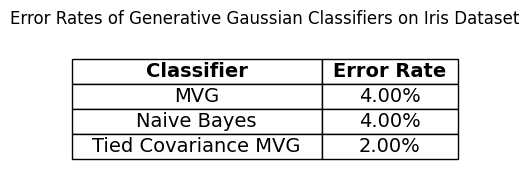

In [190]:
error_rates = [
    ("MVG", error_rate_MVG), 
    ("Naive Bayes", error_rate_NB),
    ("Tied Covariance MVG", error_rate_TiedCov)
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table_data = [[name, f"{error:.2%}"] for name, error in error_rates]
table = ax.table(cellText=table_data, colLabels=["Classifier", "Error Rate"], loc="center")

#center text in the cells
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')
    else:
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width([0, 1])
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.title("Error Rates of Generative Gaussian Classifiers on Iris Dataset")
plt.show()



## Binary tasks: log-likelihood ratios and MVG
We now focus on the same binary task we employed for LDA (see Laboratory 3), which requries classifying only two kinds of flowers, iris versicolor and iris virginica.
So, the first thing to to is to extract just the samples of classes iris-versicolor and iris-virginica from the Dataset.

In [191]:
D, L = loadDataSet('iris.csv', numFeatures)
D_not0 = D[:, L != 0]                                                   #remove the samples of class 0
L_not0 = L[L != 0]                                                      #remove the labels of class 0
(DTR, LTR), (DVAL, LVAL) = splitTrainingValidation(2/3, D_not0, L_not0) #split the dataset into training and validation sets

print("Training data shape: ", DTR.shape)
print("Training labels shape: ", LTR.shape)
print("Evaluation data shape: ", DVAL.shape)
print("Evaluation labels shape: ", LVAL.shape)

Training data shape:  (4, 66)
Training labels shape:  (66,)
Evaluation data shape:  (4, 34)
Evaluation labels shape:  (34,)


We assign to the test sample $x_{t}$ the class having the highest Posterior probability, comparing $P (C_{t} = 2 \mid \mathbf{X}_t = \mathbf{x}_t)$ and $P (C_{t} = 1 \mid \mathbf{X}_t = \mathbf{x}_t)$, assuming class $2$ is the virginica class and the *true* class, whereas class $1$ is the versicolor class and the *false* class (i.e. we are testing the hypothesis
that a flower is from the virginica class). <br>
We can jump into the *log-domain* and express the comparison in
terms of **class posterior log-ratio**, which is the log of the ratio between the two Posteriors:
$$
\log \text{r}(x_{t}) = \log \frac{P (C_{t} = 2 \mid \mathbf{X}_t = \mathbf{x}_t)}{P (C_{t} = 1 \mid \mathbf{X}_t = \mathbf{x}_t)}
$$
In the log domain this is the sum of two terms:
$$
\log \text{r}(x_{t}) = \log \frac{f_{X|C}(x_t | 2)}{f_{X|C}(x_t | 1)} +
\log \frac{P(C= 2)}{P(C=1)}
$$
So, we can see that $\log \text{r}(x_{t})$ depends on the log of the ratio between the likelihoods of the two classes, plus the log of the priors of the two classes. <br>
Since the priors do not depend on the dataset, our system should just focus on providing the first term
which is the log of the ratio of the likelihoods, so the conditionals, of the two classes, also called **log-likelihood ratio**:
$$
s(x_t) = \text{llr}(x_t) = \log \frac{f_{X|C}(x_t | 2)}{f_{X|C}(x_t | 1)} = \log f_{X|C}(x_t | 2) - \log f_{X|C}(x_t | 1) = \log \mathcal{N}(x_t | \mu_2, \Sigma_2) - \log \mathcal{N}(x_t | \mu_1, \Sigma_1)
$$
Then the classification rule is simple: we compare the $\text{llr}(x_{t})$ to the **prior log-odds** $ \left( \log \frac{P(C= 2)}{P(C=1)} \right)$, which can be considered a selected *threshold* depending on the application. This generates a decision surfaces used to separate and classify our data.


As always, given the labeled dataset, the parameters of the Gaussians are estimated using the Maximum Likelihood (ML) approach:

In [192]:
#Compute the MLE estimators for class 1 and class 2
mu_1, C_1, = compute_mu_C(DTR[:, LTR == 1])
mu_2, C_2, = compute_mu_C(DTR[:, LTR == 2])
print(f"mu_1:\n{mu_1}\nShape: {mu_1.shape}")
print(f"mu_2:\n{mu_2}\nShape: {mu_2.shape}")
print(f"C_1:\n{C_1}\nShape: {C_1.shape}")
print(f"C_2:\n{C_2}\nShape: {C_2.shape}")

mu_1:
[[5.95882353]
 [2.78529412]
 [4.32647059]
 [1.33823529]]
Shape: (4, 1)
mu_2:
[[6.5875  ]
 [2.95625 ]
 [5.571875]
 [2.053125]]
Shape: (4, 1)
C_1:
[[0.30948097 0.10851211 0.21991349 0.07186851]
 [0.10851211 0.10831315 0.09627163 0.04173875]
 [0.21991349 0.09627163 0.25018166 0.0807526 ]
 [0.07186851 0.04173875 0.0807526  0.04000865]]
Shape: (4, 4)
C_2:
[[0.41296875 0.06226562 0.29058594 0.04691406]
 [0.06226562 0.06308594 0.04564453 0.03201172]
 [0.29058594 0.04564453 0.28764648 0.04868164]
 [0.04691406 0.03201172 0.04868164 0.05874023]]
Shape: (4, 4)


In [193]:
#Then we can compute the log-likelihoods for class 1 and class 2 given the MLE parameters of the MVG distribution
#Beware: we use the VALIDATION data to compute the log-likelihoods, not the training data!
loglikelihood_1 = logpdf_GAU_ND(DVAL, mu_1, C_1)
loglikelihood_2 = logpdf_GAU_ND(DVAL, mu_2, C_2)
print(f"loglikelihood_1 Shape: {loglikelihood_1.shape}")
print(f"loglikelihood_2 Shape: {loglikelihood_2.shape}")

loglikelihood_1 Shape: (34,)
loglikelihood_2 Shape: (34,)


In [194]:
#Then we compute the 1-D array of the log-likelihood ratios
#In the log-domain, we just need to subtract the log-likelihoods of the two classes
llr_MVG = loglikelihood_2 - loglikelihood_1
print(f"llr Shape: {llr_MVG.shape}")

llr Shape: (34,)


In [195]:
llr_MVG_Sol = np.load("./solutions/llr_MVG.npy")
#Check if the log-likelihood ratios are equal to the solution
np.allclose(llr_MVG, llr_MVG_Sol) #check if the log-likelihood ratios are equal to the solution

True

For the threshold, given by the **prior log-odds** $ \left( \log \frac{P(C= 2)}{P(C=1)} \right)$, since we are treating a binary problem, we can rewrite it as follows:
$$
\text{Treshold} = \log \frac{P(C= 2)}{P(C=1)} = \log \frac{\pi}{1- \pi}
$$
where $\pi$ is the prior, application dependent, probability of observing class $2$. <br>
In our case we can assume **uniform** priors so: $\pi = P(C=2) = 1- \pi = P(C=1) = \frac{1}{2}$. <br>
Given this assumption, we can rewrite the threshold as:
$$
\text{Treshold} = \log \frac{\pi}{1- \pi} = \log \frac{1/2}{1-1/2} = 0
$$
To summarize, the classification rule is: 
$$
\text{llr}(x_{t}) = \log \mathcal{N}(x_t | \mu_2, \Sigma_2) - \log \mathcal{N}(x_t | \mu_1, \Sigma_1) \gtrless 0 \rightarrow
\begin{cases}
\text{class 2} \space \text{    if } \text{llr}(x_{t}) \geq 0 \\
\text{class 1} \space \text{    if } \text{llr}(x_{t}) < 0
\end{cases}
$$
The predictions are thus obtained by assigning label $2$ to samples whose log-likelihood ratio is greater or equal to 0,
and label $1$ to the other samples:

In [196]:
#Classification rule: assign samples whose llr_MVG >= 0 to class 2 and samples whose llr_MVG < 0 to class 1
PVAL_bin_MVG = np.where(llr_MVG >= 0, 2, 1) #assign samples whose llr_MVG >= 0 to class 2 and samples whose llr_MVG < 0 to class 1
print(f"Predictions shape: {PVAL_bin_MVG.shape}")
print(f"Predictions: {PVAL_bin_MVG}")



Predictions shape: (34,)
Predictions: [1 2 1 2 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]


Error Rate for Binary MVG Classifier:

In [197]:
error_count_bin_MVG = np.count_nonzero(PVAL_bin_MVG != LVAL)
print(f"Number of wrong predictions: {error_count_MVG}")
error_rate_bin_MVG = np.mean(PVAL_bin_MVG != LVAL)
print(f"Error Rate: {error_rate_bin_MVG:.2%}")

Number of wrong predictions: 2
Error Rate: 8.82%


Accuracy, Precision, Recall, F-1 Score for the Binary MVG Classifier:

In [198]:
print(classification_report(LVAL, PVAL_bin_MVG, digits=3))

              precision    recall  f1-score   support

           1      0.882     0.938     0.909        16
           2      0.941     0.889     0.914        18

    accuracy                          0.912        34
   macro avg      0.912     0.913     0.912        34
weighted avg      0.913     0.912     0.912        34



Now we try again to apply the same classification rule, based on the comparison of the log-likelihood ratio to an application dependent threhsold, but this time we use the **Tied Covariance MVG** model. <br>
As we've seen before, the ML solution for the class means is again the same. The
ML solution for the covariance matrix is given by the empirical within-class covariance matrix ($S_{w}$):
$$
\Sigma^* = S_{w} = \frac{1}{N} \sum_c \sum_i (x_{c,i} - \mu_c^*) (x_{c,i} - \mu_c^*)^T
$$
It's important again to note that, using (and **only using**) the ML estimators, the tied model provides the same classification
rule of **LDA**.
Additionally, if the priors are distributed **uniformly** (as in our case where we assume: $\pi = P(C=2) = 1- \pi = P(C=1) = \frac{1}{2}$), the two models are exactly **equivalent**.

In [199]:
compute_mu_C(DTR[:, LTR == 1])

(array([[5.95882353],
        [2.78529412],
        [4.32647059],
        [1.33823529]]),
 array([[0.30948097, 0.10851211, 0.21991349, 0.07186851],
        [0.10851211, 0.10831315, 0.09627163, 0.04173875],
        [0.21991349, 0.09627163, 0.25018166, 0.0807526 ],
        [0.07186851, 0.04173875, 0.0807526 , 0.04000865]]))

In [200]:
TiedCov_Params_bin = computeParams_ML_TiedCov(DTR, LTR, True) #compute the CTied and muVect for the training data usign MLE
CTied_bin = TiedCov_Params[0][1]
print(f"mu_1:\n{TiedCov_Params_bin[0][0]}\nShape: {TiedCov_Params_bin[0][0].shape}")
print(f"mu_2:\n{TiedCov_Params_bin[1][0]}\nShape: {TiedCov_Params_bin[1][0].shape}")
print(f"CTied:\n{CTied_bin}\nShape: {CTied_bin.shape}")


mu_1:
[[5.95882353]
 [2.78529412]
 [4.32647059]
 [1.33823529]]
Shape: (4, 1)
mu_2:
[[6.5875  ]
 [2.95625 ]
 [5.571875]
 [2.053125]]
Shape: (4, 1)
CTied:
[[0.23637589 0.09525344 0.1364944  0.03614529]
 [0.09525344 0.11618517 0.05768855 0.0357726 ]
 [0.1364944  0.05768855 0.14992811 0.03746458]
 [0.03614529 0.0357726  0.03746458 0.04291763]]
Shape: (4, 4)


In [202]:
#Then we can compute the log-likelihoods for class 1 and class 2 given the MLE parameters of the MVG distribution
#Beware: we use the VALIDATION data to compute the log-likelihoods, not the training data!
loglikelihood_1_TiedCov = logpdf_GAU_ND(DVAL, TiedCov_Params_bin[0][0], CTied_bin)
loglikelihood_2_TiedCov = logpdf_GAU_ND(DVAL, TiedCov_Params_bin[1][0], CTied_bin)
print(f"loglikelihood_1 Shape: {loglikelihood_1_TiedCov.shape}")
print(f"loglikelihood_2 Shape: {loglikelihood_2_TiedCov.shape}")

loglikelihood_1 Shape: (34,)
loglikelihood_2 Shape: (34,)


In [203]:
#Then we compute the 1-D array of the log-likelihood ratios
#In the log-domain, we just need to subtract the log-likelihoods of the two classes
llr_TiedCov = loglikelihood_2_TiedCov - loglikelihood_1_TiedCov
print(f"llr Shape: {llr_TiedCov.shape}")

llr Shape: (34,)


The classification rule remains the same:

In [204]:
#Classification rule: assign samples whose llr_MVG >= 0 to class 2 and samples whose llr_MVG < 0 to class 1
PVAL_bin_TiedCov = np.where(llr_TiedCov >= 0, 2, 1) #assign samples whose llr_MVG >= 0 to class 2 and samples whose llr_MVG < 0 to class 1
print(f"Predictions shape: {PVAL_bin_TiedCov.shape}")
print(f"Predictions: {PVAL_bin_TiedCov}")

Predictions shape: (34,)
Predictions: [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]


Error Rate for Binary Tied Cov. MVG Classifier:

In [205]:
error_count_bin_TiedCov = np.count_nonzero(PVAL_bin_TiedCov != LVAL)
print(f"Number of wrong predictions: {error_count_bin_TiedCov}")
error_rate_bin_TiedCov = np.mean(PVAL_bin_TiedCov != LVAL)
print(f"Error Rate: {error_rate_bin_TiedCov:.2%}")

Number of wrong predictions: 1
Error Rate: 2.94%


Accuracy, Precision, Recall, F-1 Score for the Binary Tied Cov. MVG Classifier:

In [206]:
print(classification_report(LVAL, PVAL_bin_TiedCov, digits=3))

              precision    recall  f1-score   support

           1      0.941     1.000     0.970        16
           2      1.000     0.944     0.971        18

    accuracy                          0.971        34
   macro avg      0.971     0.972     0.971        34
weighted avg      0.972     0.971     0.971        34



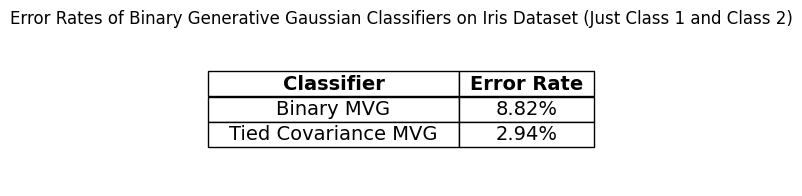

In [208]:
error_rates = [
    ("Binary MVG", error_rate_bin_MVG), 
    ("Tied Covariance MVG", error_rate_bin_TiedCov)
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table_data = [[name, f"{error:.2%}"] for name, error in error_rates]
table = ax.table(cellText=table_data, colLabels=["Classifier", "Error Rate"], loc="center")

#center text in the cells
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')
    else:
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width([0, 1])
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.title("Error Rates of Binary Generative Gaussian Classifiers on Iris Dataset (Just Class 1 and Class 2)")
plt.savefig("error_rates_binary.png", bbox_inches='tight', dpi=300) #save the figure with a resolution of 300 dpi
plt.show()